In [1]:
# Third party modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import umap

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model

from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

# Autoencoder Deep Embeddings

The following code implements a standard feed-foreward autoencoder (from [N2D](https://n2d.readthedocs.io/en/latest/), but the **N2D framework is not used**).

In [70]:
class AutoEncoder:
    """AutoeEncoder: standard feed forward autoencoder

    Parameters:
    -----------
    input_dim: int
        The number of dimensions of your input


    latent_dim: int
        The number of dimensions which you wish to represent the data as.

    architecture: list
        The structure of the hidden architecture of the networks. for example,
        the n2d default is [500, 500, 2000],
        which means the encoder has the structure of:
        [input_dim, 500, 500, 2000, latent_dim], and the decoder has the structure of:
        [latent_dim, 2000, 500, 500, input dim]

    act: string
        The activation function. Defaults to 'relu'
    """

    def __init__(
        self,
        input_dim,
        latent_dim,
        architecture=[500, 500, 2000],
        act="relu",
        x_lambda=lambda x: x,
    ):
        shape = [input_dim] + architecture + [latent_dim]
        self.x_lambda = x_lambda
        self.dims = shape
        self.act = act
        self.x = Input(shape=(self.dims[0],), name="input")
        self.h = self.x
        n_stacks = len(self.dims) - 1
        for i in range(n_stacks - 1):
            self.h = Dense(
                self.dims[i + 1], activation=self.act, name="encoder_%d" % i
            )(self.h)
        self.encoder = Dense(self.dims[-1], name="encoder_%d" % (n_stacks - 1))(self.h)
        self.decoded = Dense(self.dims[-2], name="decoder", activation=self.act)(
            self.encoder
        )
        for i in range(n_stacks - 2, 0, -1):
            self.decoded = Dense(
                self.dims[i], activation=self.act, name="decoder_%d" % i
            )(self.decoded)
        self.decoded = Dense(self.dims[0], name="decoder_0")(self.decoded)

        self.Model = Model(inputs=self.x, outputs=self.decoded)
        self.encoder = Model(inputs=self.x, outputs=self.encoder)
        self.__hist = None

    def fit(
        self,
        x,
        batch_size,
        epochs,
        loss,
        optimizer,
        weights,
        verbose,
        weight_id,
        patience,
    ):
        """fit: train the autoencoder.

            Parameters:
                -------------
                x: array-like
                the data you wish to fit

            batch_size: int
            the batch size

            epochs: int
            number of epochs you wish to run.

            loss: string or function
            loss function. Defaults to mse

            optimizer: string or function
            optimizer. defaults to adam

            weights: string
            if weights is used, the path to the pretrained nn weights.

            verbose: int
            how verbose you wish the autoencoder to be while training.

            weight_id: string
            where you wish to save the weights

            patience: int
            if not None, the early stopping criterion
            """

        if (
            weights is None
        ):  # if there are no weights to load for the encoder, make encoder
            self.Model.compile(loss=loss, optimizer=optimizer)

            if weight_id is not None:  # if we are going to save the weights somewhere
                if patience is not None:  # if we are going to do early stopping
                    callbacks = [
                        EarlyStopping(monitor="loss", patience=patience),
                        ModelCheckpoint(
                            filepath=weight_id, monitor="loss", save_best_only=True
                        ),
                    ]
                else:
                    callbacks = [
                        ModelCheckpoint(
                            filepath=weight_id, monitor="loss", save_best_only=True
                        )
                    ]
                # fit the model with the callbacks
                self.__hist = self.Model.fit(
                    self.x_lambda(x),
                    x,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=verbose,
                )
                self.Model.save_weights(weight_id)
            else:  # if we are not saving weights
                if patience is not None:
                    callbacks = [EarlyStopping(monitor="loss", patience=patience)]
                    self.__hist = self.Model.fit(
                        self.x_lambda(x),
                        x,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=verbose,
                    )
                else:
                    self.__hist = self.Model.fit(
                        self.x_lambda(x),
                        x,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                    )
        else:  # otherwise load weights
            self.Model.load_weights(weights)

    def plot_loss(self):
        """
        """
        plt.subplots(figsize=(8, 5))
        sns.lineplot(np.arange(len(self.__hist.history['loss'])),
                     self.__hist.history['loss'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')

## Training The Encodings

The autoencoder is used to learn a 2D embedding of the standardized data.

**The training process produces a lot of text**

In [8]:
data = pd.read_csv('../../courses/Machine_Learning_1/home-credit-default-risk/_data/std_df.csv')

In [71]:
ae = AutoEncoder(data.shape[-1], 2)

In [72]:
ae.fit(
    data,
    batch_size=10000,
    epochs=500,
    loss="mse",
    optimizer="adam",
    weights=None,
    verbose=1,
    weight_id=None,
    patience=None,
)

Epoch 1/500
307511/307511 [==============================] - 7s 22us/sample - loss: 0.2258
Epoch 2/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1791
Epoch 3/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1665
Epoch 4/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1551
Epoch 5/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1457
Epoch 6/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1421
Epoch 7/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1343
Epoch 8/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1286
Epoch 9/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1247
Epoch 10/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1237
Epoch 11/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.12

## Training Loss

The autoencoder appears to be able to learn an embedding from the data based on the validation loss.

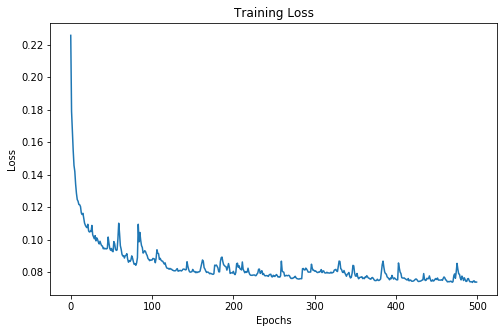

In [73]:
ae.plot_loss()

## Visualize the Embedding

Predict the encodings from the encoder then plot the 2D embedding.

Its kind of a weird looking star.

In [82]:
vals = ae.encoder.predict(data)

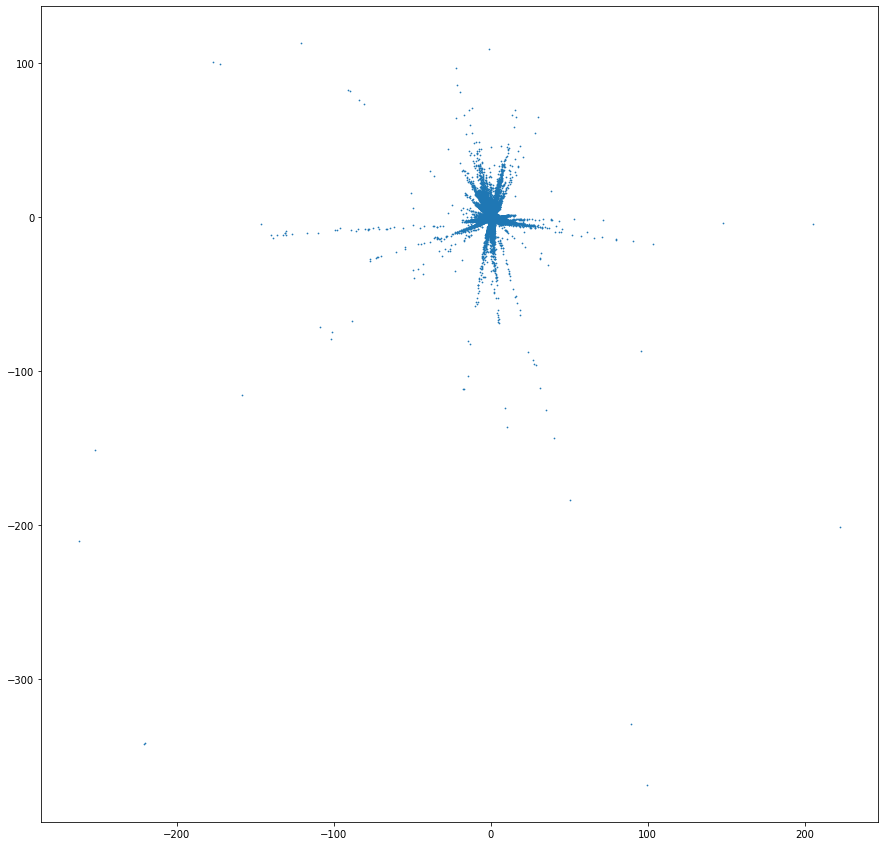

In [91]:
plt.figure(figsize = (15,15))
plt.scatter(vals[:, 0], vals[:, 1], s = 0.5)

# Clustering

## k-Means Cluster

Visually, only some of the clusters produced by k-Means appear to be reasonable.
Specifically, least one cluster near the center appears to be questionable.

In [122]:
kmeans = KMeans(random_state=42, n_clusters=8)

In [107]:
labels = mix_type.fit_predict(vals)

In [108]:
pd.Series(labels).value_counts()

1    261888
3     23408
0     19895
2      2320
dtype: int64

In [123]:
k_labels = kmeans.fit_predict(vals)

In [124]:
pd.Series(k_labels).value_counts()

3    271136
1     20610
0      9958
6      4400
7      1328
4        58
2        17
5         4
dtype: int64

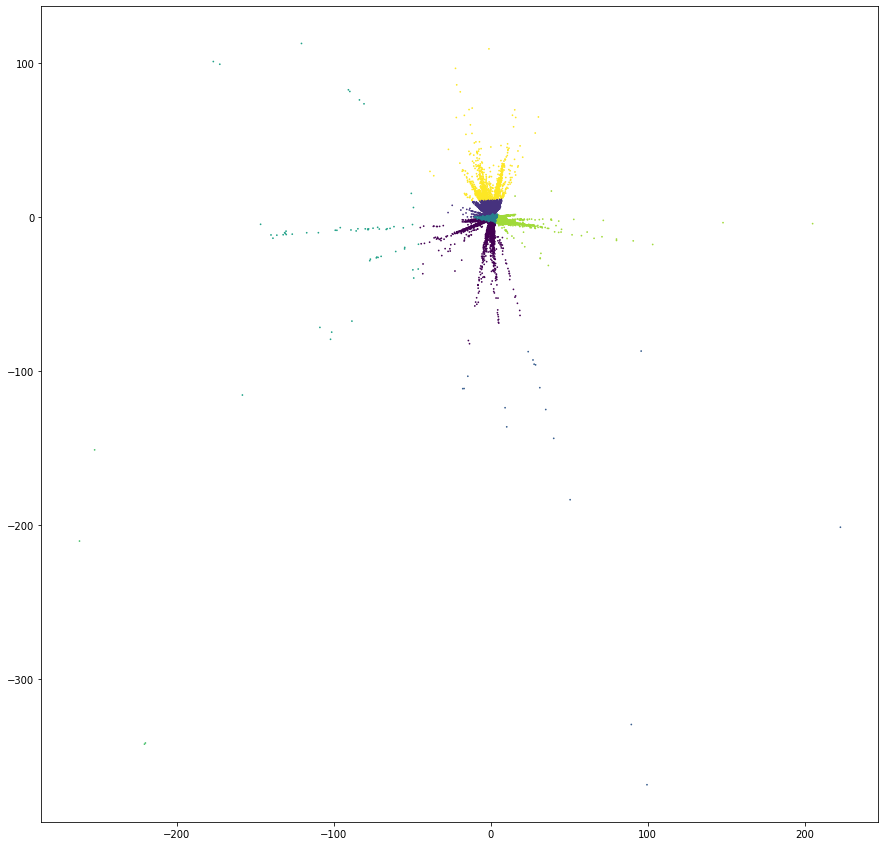

In [125]:
plt.figure(figsize = (15,15))
plt.scatter(vals[:, 0], vals[:, 1], s = 0.5, c = k_labels)

## Agglomerative Clustering

The 'core' clusters created by agglomerative clustering appear to be reasonable.
Also, it tends to pickup on noise.

Note: downsampling is required to run agglomerative clustering due to the size of the dataset.

In [180]:
ind = np.random.choice(np.arange(vals.shape[0]), replace = False, size = 30000)

In [353]:
sil_scores = list()
sizes = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20]

for n in sizes:
    sil_scores.append(
        silhouette_score(vals[ind , :], AgglomerativeClustering(n_clusters=n).fit_predict(vals[ind , :]))
    )

There is a high silhouette score below `n_clusters = 5`,
however, essentially only 1 cluster is actually chosen in these sets.
There appears to be an increase in mean silhouette score with increase in number of clusters,
but a smaller number of clusters may be useful for interpretation.
Additionally, tuning may improve performance.

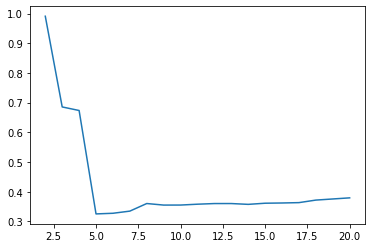

In [355]:
plt.plot(sizes, sil_scores)

### Sample Clustering

Mostly using the default here. 
Picked 8 for `n_clusters` because the silhouette score started to come up a bit.
With the number clusters set to 8, possibly 5 clusters appear to come up (maybe fewer). 
A visualization of the clusters is shwon below.

In [369]:
aglom = AgglomerativeClustering(n_clusters=8)

In [370]:
labels = aglom.fit_predict(vals[ind , :])

In [371]:
pd.Series(labels).value_counts()

3    18816
0     9104
6     1540
4      394
2      135
1        8
5        2
7        1
dtype: int64

In [372]:
silhouette_score(vals[ind , :], labels)

0.3600225

In [360]:
data_small = data.iloc[ind].copy()

In [361]:
#data_small['cluster'] = labels

(-50, 50)

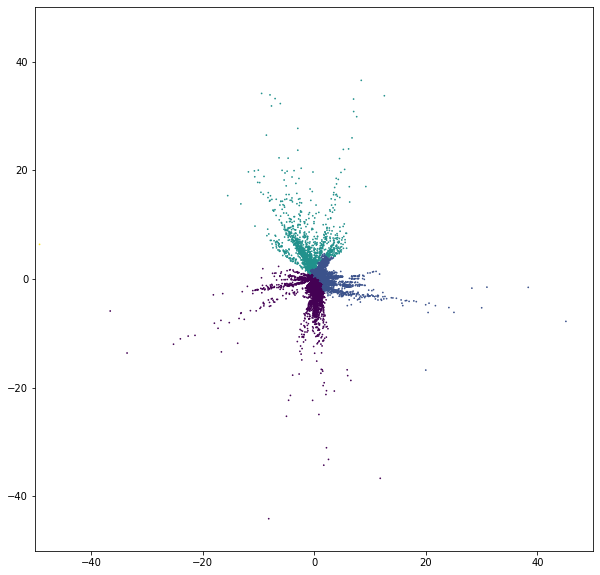

In [367]:
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

Note that setting `_clusters` to 2 or 3 basically just picks one primary cluster.
Clustering for `n = 2` shown below.

(-50, 50)

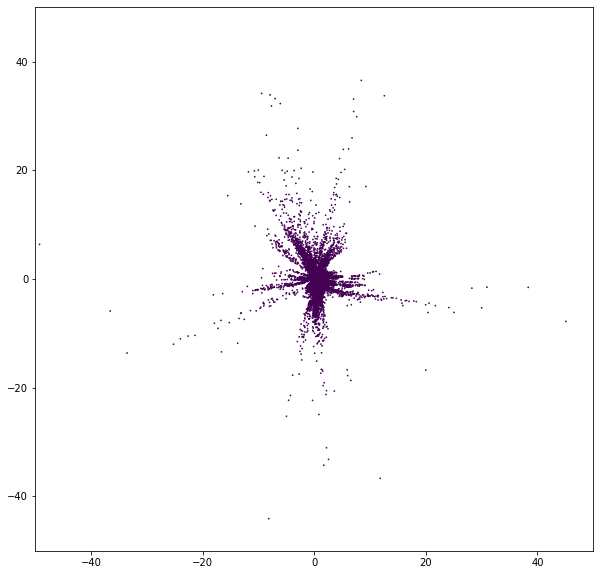

In [373]:
aglom = AgglomerativeClustering(n_clusters=2)
labels = aglom.fit_predict(vals[ind , :])
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

# Interpretation by Decision Trees

In [348]:
dtc = DecisionTreeClassifier(random_state=42,
                             max_leaf_nodes=5,
                            min_samples_leaf=500)

In [349]:
dtc.fit(data_small.iloc[:, :100], labels)
preds = dtc.predict(data_small.iloc[:, :100])

In [350]:
pd.Series(preds).value_counts()

1    18231
4    10413
6     1356
dtype: int64

In [340]:
labels

array([1, 1, 2, ..., 4, 1, 1])

In [368]:
pd.crosstab(preds, labels)

col_0,0,1,2,3,4
row_0,,,,,
1,17217,999,10,1,4
4,1988,7823,599,0,3
6,7,282,1066,0,1


In [351]:
# Creates dot file named tree.dot
export_graphviz(
            dtc,
            out_file =  "./myTreeName.dot",
            feature_names = list(data_small.iloc[:, :100].columns),
            class_names = dtc.classes_.astype(str),
            filled = True,
            rounded = True)

Generate png with 
```bash
$ dot -Tpng myTreeName.dot -o tree.png
```

In [242]:
data_small.iloc[:, :100]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,EMPLOYED,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_TYPE_Another type of loan
277304,-0.370400,1.19000,0.31350,0.9795,0.03620,2.16200,-1.37000,0.69240,-0.1741,-0.1686,...,0,0,1,0.2500,0.7500,0.0,1.0000,0.0000,0.0,0.0
229414,0.426800,0.38800,0.64500,0.3700,0.56600,-0.62060,0.55200,-1.62500,-0.5910,-0.5894,...,0,0,1,0.0000,1.0000,0.0,1.0000,0.0000,0.0,0.0
118157,0.331800,-0.35910,-0.48900,-0.2269,0.25950,1.04200,0.21890,-1.50700,-0.5910,-0.5894,...,0,0,1,0.6250,0.3750,0.0,1.0000,0.0000,0.0,0.0
24393,-0.427200,-0.87350,-1.22900,-0.7876,1.56900,-0.84700,1.13300,1.00800,-0.5910,-0.5894,...,0,0,0,0.0000,1.0000,0.0,1.0000,0.0000,0.0,0.0
158267,-0.028670,0.95460,1.92600,0.9795,-0.45800,1.78900,-1.21800,0.93000,0.6597,0.6730,...,0,0,1,0.7500,0.2500,0.0,1.0000,0.0000,0.0,0.0
304625,-0.427200,-0.98540,-1.17200,-0.9090,-0.75440,0.12960,0.47020,0.98440,-0.5910,-0.5894,...,0,0,1,0.6665,0.3333,0.0,1.0000,0.0000,0.0,0.0
20129,0.047240,0.24460,0.70260,0.4312,0.73630,-0.15430,-1.37600,-0.69200,-0.5910,-0.5894,...,0,0,1,0.2500,0.7500,0.0,1.0000,0.0000,0.0,0.0
47167,0.199100,-0.37040,-0.31790,-0.2391,0.16300,2.64000,-0.64940,-1.79400,-0.1741,-0.1686,...,0,0,1,0.7144,0.2856,0.0,1.0000,0.0000,0.0,0.0
52075,0.047240,1.71300,0.73800,1.5890,-0.99070,0.83740,-0.37670,-0.49500,1.4940,1.5140,...,0,0,1,0.1428,0.8570,0.0,1.0000,0.0000,0.0,0.0
182778,-0.237400,-0.87400,-0.29660,-0.8486,-1.40000,-0.75340,-0.10364,-1.57200,-0.5910,-0.5894,...,0,0,1,1.0000,0.0000,0.0,1.0000,0.0000,0.0,0.0
